<i>Copyright (c) Microsoft Corporation. All rights reserved.</i>

<i>Licensed under the MIT License.</i>

# Training an Action Recognition Model

In this notebook, we show how to finetune the pretrained R(2+1)D model. For this notebook, we'll be using a dataset that we created to demonstrate how to load, fine-tune, and evaluate and action recognition model.


### Initialization
Import all the functions we need.

In [1]:
import sys

sys.path.append("../../")

import time
import os
import numpy as np
import warnings
import scrapbook as sb

import torch
import torchvision
from pathlib import Path
from sklearn.metrics import accuracy_score

from utils_cv.action_recognition.data import Urls
from utils_cv.action_recognition.dataset import VideoDataset
from utils_cv.action_recognition.model import VideoLearner 
from utils_cv.common.gpu import system_info
from utils_cv.common.data import data_path, unzip_url

system_info()
warnings.filterwarnings('ignore')

3.6.8 |Anaconda, Inc.| (default, Dec 30 2018, 01:22:34) 
[GCC 7.3.0] 

PyTorch 1.2.0 

Torch-vision 0.4.0a0 

Available devices:
0: Tesla V100-PCIE-16GB


This shows your machine's GPUs (if it has any) and the computing device torch/torchvision is using.

In [2]:
# Ensure edits to libraries are loaded and plotting is shown in the notebook.
%reload_ext autoreload
%autoreload 2
%matplotlib inline
%load_ext blackcellmagic

Next, set some model runtime parameters. We use the `unzip_url` helper function to download and unzip the data used in this example notebook.

In [3]:
# Your data
DATA_PATH = unzip_url(Urls.milk_bottle_action_path, exist_ok=True)
# Number of consecutive frames used as input to the DNN. Recommended: 32 for high accuracy, 8 for inference speed.
MODEL_INPUT_SIZE = 16
# Number of training epochs
EPOCHS = 16
# Batch size. Reduce if running out of memory.
BATCH_SIZE = 8
# Learning rate
LR = 0.0001

---
# Prepare Action Recognition Dataset

In this notebook, we use a toy dataset called *Milk Bottle Actions*, which consists of 60 clips of 2 actions: `{opening, pouring}`. The same objects appear in both classes. 

After downloading the dataset, the `unzip_url` helper function will also unzip the dataset to the `data` directory.

In [4]:
os.listdir(Path(DATA_PATH))

['pouring',
 'milk_bottle_actions_train_split_1.txt',
 'opening',
 'milk_bottle_actions_valid_split_1.txt']

You'll notice that we have two different folders inside:
- `/pouring`
- `/opening`

Action videos can be stored as follows:

```
/data
+-- action_class_1
|   +-- video_01.mp4
|   +-- video_02.mp4
|   +-- ...
+-- action_class_2
|   +-- video_11.mp4
|   +-- video_12.mp4
|   +-- ...
+-- ...
```

For action recognition, the way data is stored can be as straight forward as putting the videos for each action inside a folder named after the action. 

# Load Images

To load the data, we need to create a VideoDataset object using the `VideoDataset` helper class. This class knows how to extract generate the dataset based on the above format. We simply pass it the path to the root dir of our dataset.

In [5]:
data = VideoDataset(DATA_PATH, batch_size=BATCH_SIZE, sample_length=MODEL_INPUT_SIZE)

The `VideoDataset` will automatically divide the data into a training/validation set and set up the dataloaders that PyTorch uses. Lets inspect our Datasets/DataLoaders to make sure the train/test split looks right.

In [6]:
print(
    f"Training dataset: {len(data.train_ds)} | Training DataLoader: {data.train_dl} \
    \nTesting dataset: {len(data.test_ds)} | Testing DataLoader: {data.test_dl}"
)

Training dataset: 45 | Training DataLoader: <torch.utils.data.dataloader.DataLoader object at 0x7f488dd958d0>     
Testing dataset: 15 | Testing DataLoader: <torch.utils.data.dataloader.DataLoader object at 0x7f482f20c0b8>


Lets take a look at the data by briefly looking at the frames.

<Figure size 432x288 with 0 Axes>

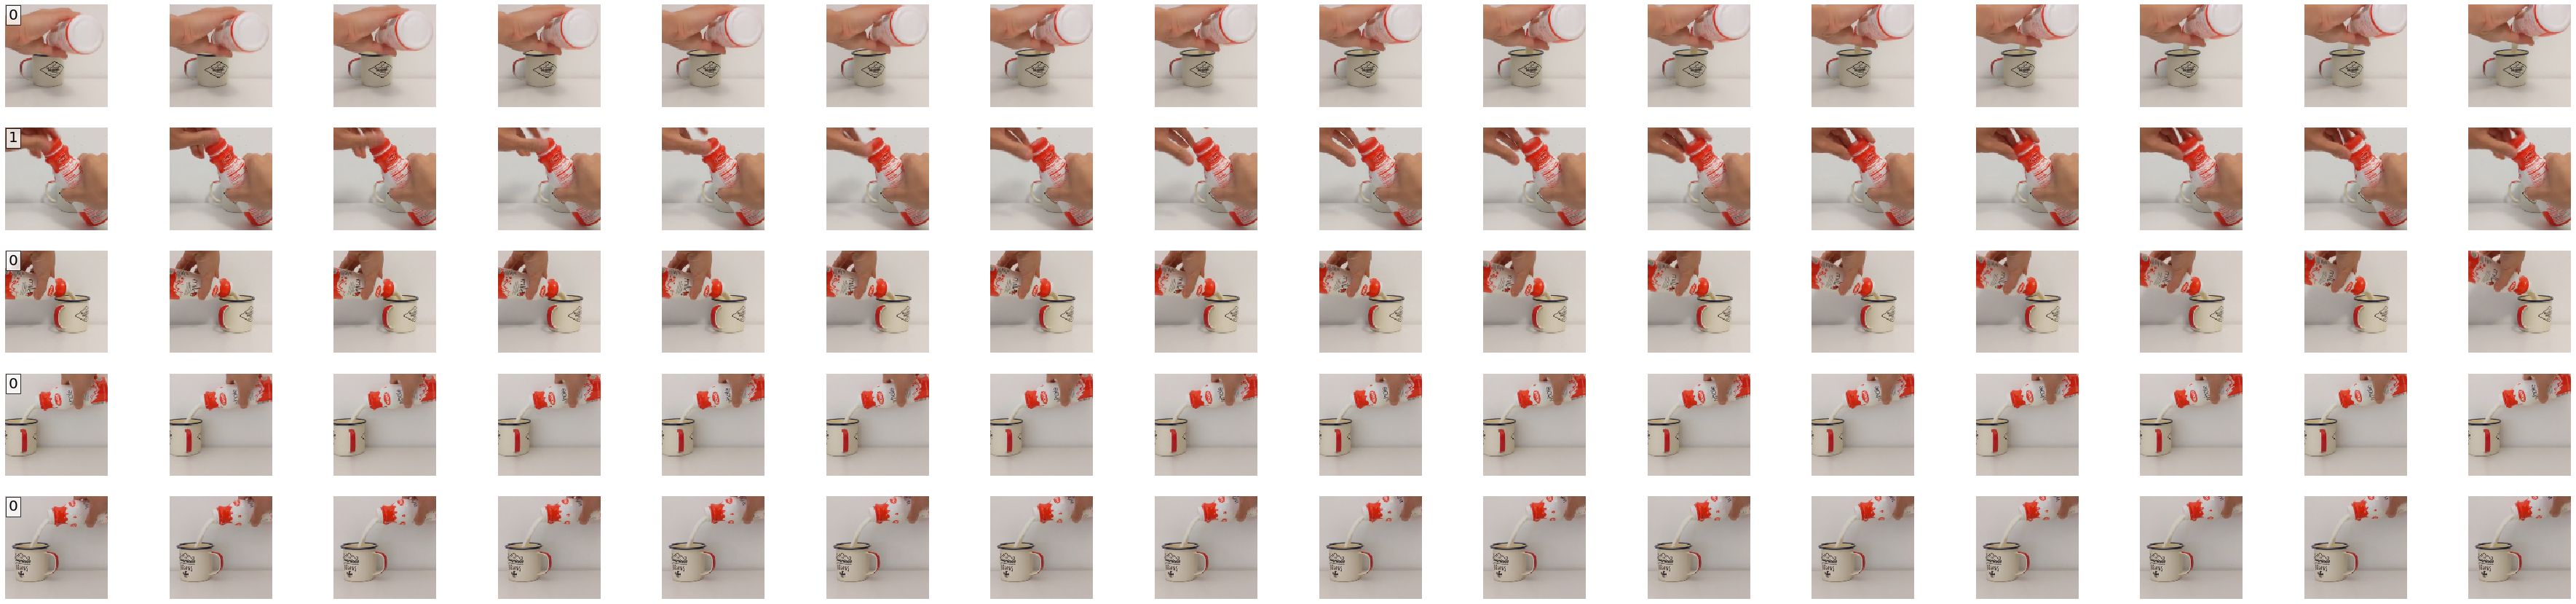

In [7]:
data.show_batch(rows=5, train_or_test="test")

# Finetune a Pretrained Model

By default, our VideoLearner's R(2+1)D model is pretrained on __ig65m__ which is based of 65 million instagram videos. You can find more information on the dataset in this paper: https://arxiv.org/pdf/1905.00561.pdf

When we initialize the VideoLearner, we simply pass in the dataset. By default, the object will set the model to torchvision's ig65m R(2+1)D pre-trained model. Alternatively, we can also select the R(2+1)D model pretrained on the __kinetics__ dataset or even pass in the model we want to use. 

In [8]:
learner = VideoLearner(data, num_classes=2)

Loading r2plus1d_34_32_ig65m model


Using cache found in /home/jiata/.cache/torch/hub/moabitcoin_ig65m-pytorch_master


The dataset we're using only has two actions: __opening__ and __pouring__. This means that our fully connected (FC) layer must only have an output of two. We can check that this is the case by inspecting the model's FC layer.

In [9]:
learner.model.fc

Linear(in_features=512, out_features=2, bias=True)

Fine-tune the model using the `learner`'s `fit` function. Here we pass in the learning rate.

Params to learn:
	full network
Epoch 1 =========================================================
lr=[0.0001]
train took 7.88 sec | loss = 0.7213 | top1_acc = 40.0000  
valid took 1.86 sec | loss = 0.6902 | top1_acc = 66.6667  
Epoch 2 =========================================================
lr=[0.0001]
train took 5.33 sec | loss = 0.7482 | top1_acc = 24.4444  
valid took 1.31 sec | loss = 0.6859 | top1_acc = 66.6667  
Epoch 3 =========================================================
lr=[0.0001]
train took 5.35 sec | loss = 0.6988 | top1_acc = 55.5556  
valid took 1.38 sec | loss = 0.6728 | top1_acc = 60.0000  
Epoch 4 =========================================================
lr=[0.0001]
train took 5.36 sec | loss = 0.6965 | top1_acc = 53.3333  
valid took 1.30 sec | loss = 0.6898 | top1_acc = 53.3333  
Epoch 5 =========================================================
lr=[0.0001]
train took 5.05 sec | loss = 0.6795 | top1_acc = 53.3333  
valid took 1.33 sec | loss = 0.6821 | top1_acc =

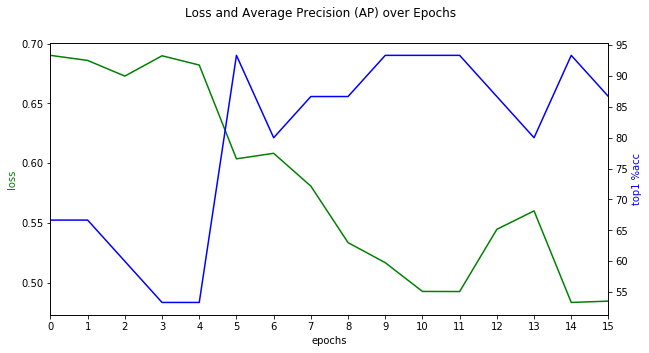

In [10]:
learner.fit(lr=LR, epochs=EPOCHS)

# Evaluate

Reported accuracy from "Closer look" paper: 74.5% (clip accuracy of 66.1% on split1 based on VMZ repo)

1. sample 10 clips uniformly sampled from each test video: [10 x 3 x (8 or 32) x 112 x 112]
2. calculate clip-level accuracy: Use 10 batch and infer
3. calculate video-level accuracy by averaging them
4. average over the clips

In [11]:
ret = learner.evaluate()

15 samples of torch.Size([3, 16, 112, 112])
Avg. inference time per video (15 clips) = 216.80707590920585 ms
Video prediction accuracy = 0.6428571428571429
Clip prediction accuracy = 0.65


# Conclusion
Using the concepts introduced in this notebook, you can bring your own dataset and train an action recognition model to detect specific objects of interest for your scenarios.

In [ ]:
# Preserve some of the notebook outputs
sb.glue("vid_pred_accuracy", accuracy_score(ret["video_trues"], ret["video_preds"]))
sb.glue("clip_pred_accuracy", accuracy_score(ret["clip_trues"], ret["clip_preds"]))